In [21]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
import seaborn as sns

import bayesflow as bf
import tensorflow as tf

from scipy.stats import halfnorm, maxwell

from functools import partial
from IPython.display import HTML
from bayesflow.simulation import Prior, Simulator, GenerativeModel

 ### Simulator

In [22]:
# Helper function for agent initialization
def initialize_agents(
        num_agents: int = 12,
        boundary_size: float = 10.0,
        rng=None
):
    if rng is None:
        rng = np.random.default_rng()

    positions = rng.uniform(size=(num_agents, 2)) * boundary_size
    directions = rng.uniform(size=num_agents) * 2 * np.pi

    return positions, directions

In [23]:
# Simulator
def simulator_fun(
    theta: np.ndarray = None,
    num_agents: int = 12,
    num_timesteps: int = 100,
    boundary_size: float = 10.0,
    r_0: float = 5.0,
    rng=None
):
    if rng is None:
        rng = np.random.default_rng()

    if theta is not None:
        radius, speed, eta = theta[0], theta[1], theta[2]
    else:
        radius, speed, eta = 2.0, 1.0, 1.0

    trajectories = np.zeros((num_timesteps + 1, num_agents, 2))
    headings = np.zeros((num_timesteps + 1, num_agents, 1))

    positions, directions = initialize_agents(num_agents, boundary_size, rng)
    trajectories[0] = positions
    headings[0] = directions[:, np.newaxis]

    for t in range(num_timesteps):
        new_directions = np.zeros(num_agents)
        for i in range(num_agents):
            neighbors = []
            for j in range(num_agents):
                if i != j and np.linalg.norm(positions[i] - positions[j]) < radius:
                    neighbors.append(directions[j])
            if neighbors:
                avg_direction = np.arctan2(np.mean(np.sin(neighbors)), np.mean(np.cos(neighbors)))
                new_directions[i] = avg_direction + rng.uniform(-eta * 0.5, eta * 0.5)
            else:
                new_directions[i] = directions[i]

        directions = new_directions
        
        # Update position upon new direction
        positions[:, 0] += speed * np.cos(directions)
        positions[:, 1] += speed * np.sin(directions)
        
        # Assumes periodic boundary condition
        positions = np.mod(positions, boundary_size)

        trajectories[t + 1] = positions
        headings[t + 1] = directions[:, np.newaxis]

    return np.concatenate((trajectories, headings), axis=-1, dtype=np.float32)

To make sure that it works, we run the simulator in one default setting and see if it generate sensible data points

In [24]:
test_path = simulator_fun()
test_path

array([[[ 8.139798  ,  6.283899  ,  5.684123  ],
        [ 5.157309  ,  5.597642  ,  4.948064  ],
        [ 7.182185  ,  4.1457295 ,  5.7578883 ],
        ...,
        [ 7.2549376 ,  9.429172  ,  5.7554564 ],
        [ 1.5973868 ,  8.592876  ,  5.325724  ],
        [ 8.33162   ,  5.2386737 ,  1.1401439 ]],

       [[ 8.922894  ,  6.905801  ,  0.67116916],
        [ 6.0235105 ,  5.0979466 , -0.52324706],
        [ 7.802566  ,  4.9300303 ,  0.90156823],
        ...,
        [ 7.0728908 ,  8.445882  , -1.7538642 ],
        [ 0.74798024,  9.120615  ,  2.5856562 ],
        [ 9.139963  ,  4.649962  , -0.6294643 ]],

       [[ 9.837847  ,  6.50224   , -0.41540542],
        [ 7.0171723 ,  5.2103567 ,  0.11264812],
        [ 8.749341  ,  4.608134  , -0.32773215],
        ...,
        [ 6.890844  ,  7.462592  , -1.7538642 ],
        [ 9.898574  ,  9.648355  ,  2.5856562 ],
        [ 9.991255  ,  5.174656  ,  0.5523555 ]],

       ...,

       [[ 3.0736187 ,  2.94166   , -0.9901581 ],
        [ 7

Then, to visualize the simulation even better, we can make an animation of agent behaviors showing all trajectories together, and visually inspect the emergent movement pattern.

In [25]:
# Helper function for animation
def animate(paths, boundary_size = 10.0):
    
    positions = paths[:,:,0:2]
    directions = paths[:,:,2:]
    
    fig, ax = plt.subplots(figsize=(4, 4))


    def update(frame):
        ax.clear()
        quiver = ax.quiver(positions[frame, :, 0], positions[frame, :, 1], np.cos(directions[frame]), np.sin(directions[frame]))
        quiver.set_offsets(positions[frame])
        quiver.set_UVC(np.cos(directions[frame]), np.sin(directions[frame]))
        ax.set_xlim(0, boundary_size)
        ax.set_ylim(0, boundary_size)
        return quiver,

    a = animation.FuncAnimation(fig, update, frames=len(positions), blit=True, repeat=False)
    plt.title("Vicsek Model")
    plt.xlabel("X")
    plt.ylabel("Y")
    
    return a

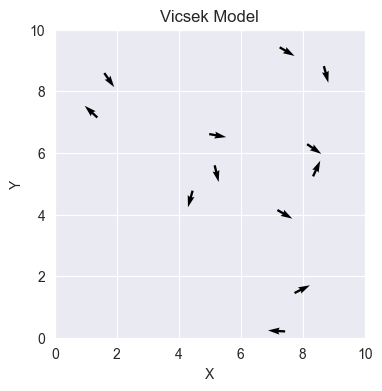

In [26]:
a = animate(test_path)

In [27]:
HTML(a.to_jshtml())

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


### Priors

For our choice of prior distributions, we generally choose base distributions that have a lower bound of 0 with a relatively sharp finite peak. In practice, an upper-bounded distribution would also be specified so that there is a full physical constraint for more realistic simulation. However, we intend to avoid choosing uninformed priors everywhere we can 

\begin{align}
    r &\sim \mathrm{Maxwell}(2),\\
    v &\sim \mathrm{Maxwell}(1),\\
    \eta &\sim \mathrm{HalfNormal}(0, 1).
\end{align}

In [42]:
def prior_fun(rng=None):
    
    if rng is None:
        rng = np.random.default_rng()
        
    r = maxwell.rvs(2.)
    v = maxwell.rvs(1.)
    eta = halfnorm.rvs(0., 1.)
    
    return np.array([r, v, eta], dtype=np.float32)

Again, making sure that it works.

In [43]:
test_prior = [prior_fun() for _ in range(10)]
test_prior

[array([2.6011539, 1.6354376, 0.6190891], dtype=float32),
 array([2.6378205, 2.6789737, 1.9639999], dtype=float32),
 array([3.4792807 , 1.7141854 , 0.42351806], dtype=float32),
 array([4.185052  , 3.277827  , 0.89535964], dtype=float32),
 array([4.027393 , 3.0105698, 1.1733787], dtype=float32),
 array([3.7149742 , 2.2635279 , 0.49480626], dtype=float32),
 array([4.1357174, 3.164116 , 0.7217845], dtype=float32),
 array([2.3645823, 1.6525315, 0.2164696], dtype=float32),
 array([3.455745  , 1.5774494 , 0.35129708], dtype=float32),
 array([4.1828833 , 2.5395653 , 0.25308216], dtype=float32)]

Test again by putting the output of `prior_fun()` as an input for `simulator_fun()`

In [44]:
test_simulator = simulator_fun(theta=prior_fun())
test_simulator.shape

(101, 12, 3)

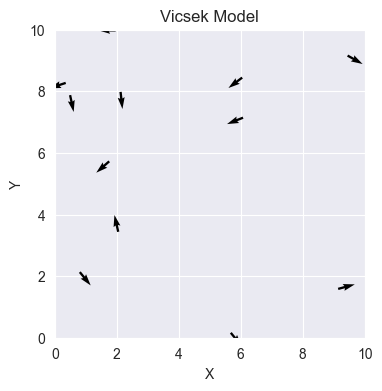

In [45]:
a = animate(test_simulator)

In [46]:
HTML(a.to_jshtml())

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


### Generative Model

In [50]:
param_names = [r'$r$', r'$v$', r'$\eta$']

In [51]:
prior = Prior(prior_fun=prior_fun, param_names=param_names)
prior_means, prior_stds = prior.estimate_means_and_stds(n_draws=10000)
prior_means, prior_stds

(array([[3.5850754, 2.6005602, 0.7959017]], dtype=float32),
 array([[0.674863 , 0.6727557, 0.6017379]], dtype=float32))

In [52]:
simulator = Simulator(simulator_fun=simulator_fun)

In [53]:
model = GenerativeModel(prior=prior, simulator=simulator, simulator_is_batched=False, name="Simple Vicsek")

INFO:root:Performing 2 pilot runs with the Simple Vicsek model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 3)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 101, 12, 3)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


### Prior Checks

Prior predictive checks and prior pushforward checks

In [55]:
test_sim = model(10)
test_sim['prior_draws'].astype(np.float32)

array([[4.0075083 , 1.8000773 , 0.60751134],
       [3.935991  , 3.194031  , 1.303253  ],
       [3.540127  , 2.4078393 , 0.3166584 ],
       [4.8801575 , 3.1297657 , 0.5193424 ],
       [3.4006386 , 2.1089065 , 1.3142276 ],
       [3.68992   , 2.4711185 , 0.82524085],
       [4.0792413 , 2.2781882 , 1.9378524 ],
       [3.5068786 , 3.0932062 , 0.57144123],
       [2.6459544 , 2.0806758 , 2.0237353 ],
       [3.517553  , 3.3108559 , 0.06427984]], dtype=float32)

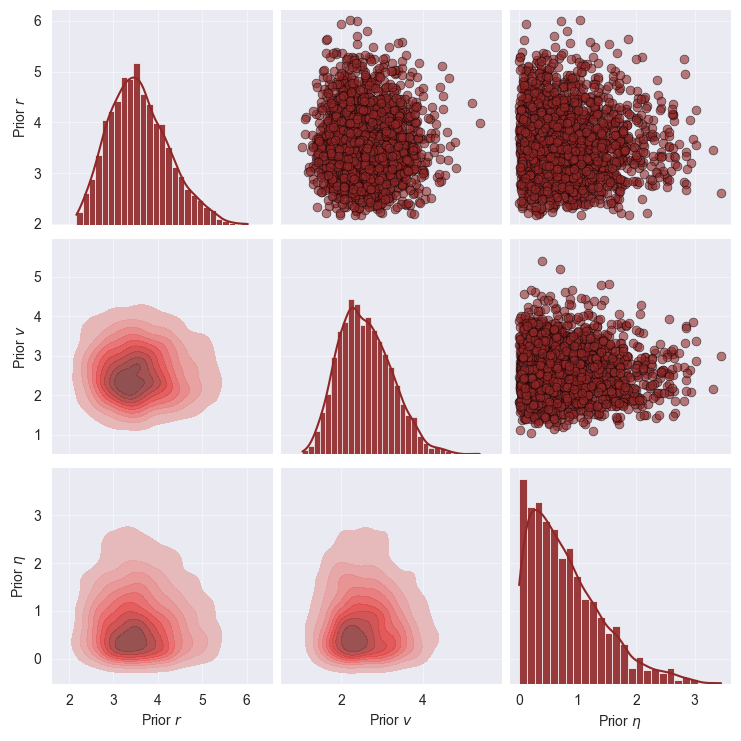

In [56]:
q = prior.plot_prior2d()

In [57]:
def average_velocity(velocities):
    
    n_timesteps = velocities.shape[0]
    avg = np.zeros(n_timesteps)
    
    for i in range(n_timesteps):
        avg[i] = np.abs(np.sum(velocities[i], axis=-1)) / velocities.shape[1]
        
    return avg

In [58]:
sim_velocities = test_sim['sim_data'][:,:,:,-1]
sim_velocities.shape

(10, 101, 12)

In [59]:
drift = test_sim['prior_draws'][:,1]
drift[2]

2.4078393

In [60]:
avg_velocities = np.zeros((10, 101))
for i in range(sim_velocities.shape[0]):
    avg_velocities[i] = average_velocity(sim_velocities[i])

avg_velocities

array([[3.25697263, 0.40311337, 0.27269886, ..., 0.4086775 , 0.42710479,
        0.32721833],
       [2.99813843, 1.61274306, 1.64850076, ..., 0.99722242, 0.8868653 ,
        1.00933361],
       [2.78383382, 0.29859553, 0.98377387, ..., 1.95706081, 1.91308133,
        1.92425442],
       ...,
       [3.37294579, 0.06401098, 0.58220069, ..., 2.65350723, 2.72589429,
        2.68395297],
       [4.14631971, 0.07734471, 1.39054124, ..., 2.01166916, 1.84999148,
        1.97121747],
       [2.98272292, 0.63327225, 0.14667567, ..., 1.51704423, 1.51107264,
        1.51030954]])

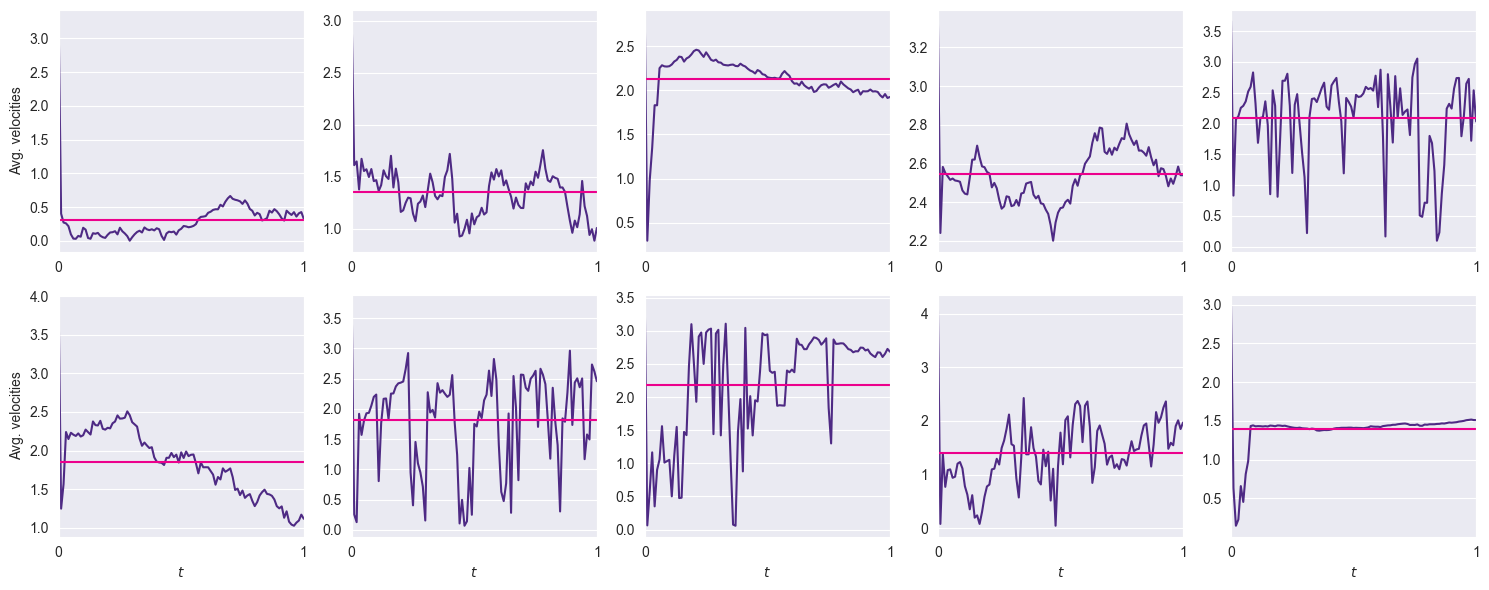

In [61]:
import pandas as pd

f, axarr = plt.subplots(2, 5, figsize=(15, 6))

for i, ax in enumerate(axarr.flat):
    sns.lineplot(x=np.linspace(0., 1., 101), y=avg_velocities[i], sort=False, ax=ax, color="#4e2a84")
    ax.axhline(y=np.mean(avg_velocities[i]),color="#ec008c")
    ax.set(xticks=[0, 1], xlim=[0, 1])
    
    if i > 4:
        ax.set_xlabel(r"$t$")
    if i % 5 == 0:
        ax.set_ylabel("Avg. velocities")
    
f.tight_layout()

In [62]:
test_sim['prior_draws']

array([[4.0075083 , 1.8000773 , 0.60751134],
       [3.935991  , 3.194031  , 1.303253  ],
       [3.540127  , 2.4078393 , 0.3166584 ],
       [4.8801575 , 3.1297657 , 0.5193424 ],
       [3.4006386 , 2.1089065 , 1.3142276 ],
       [3.68992   , 2.4711185 , 0.82524085],
       [4.0792413 , 2.2781882 , 1.9378524 ],
       [3.5068786 , 3.0932062 , 0.57144123],
       [2.6459544 , 2.0806758 , 2.0237353 ],
       [3.517553  , 3.3108559 , 0.06427984]], dtype=float32)

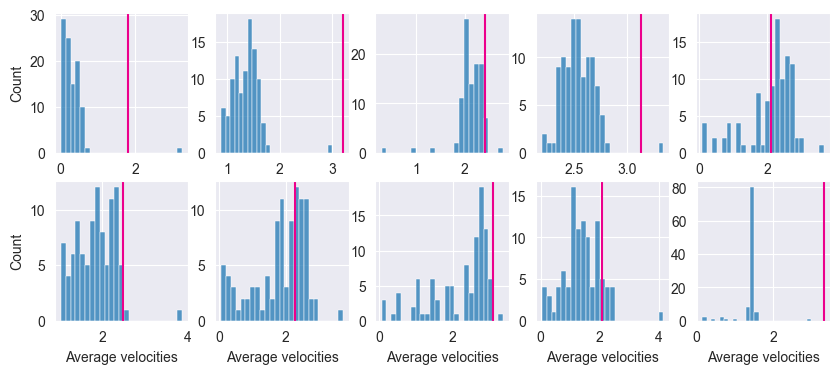

In [63]:
f, axarr = plt.subplots(2, 5, figsize=(10, 4))

for i, ax in enumerate(axarr.flat):
    sns.histplot(avg_velocities[i], bins=25, ax=ax)
    ax.axvline(x=test_sim["prior_draws"][i,1],color="#ec008c")
    
    if i > 4:
        ax.set_xlabel("Average velocities")
    if i % 5 == 0:
        ax.set_ylabel("Count")
    else:
        ax.set_ylabel("")

### Configurator

In [149]:
def configurator(input_dict: dict = None, time_embedding: bool = False):
    output_dict = {}

    theta = input_dict['prior_draws']
    output_dict['parameters'] = theta

    x = input_dict['sim_data']
    
    # Standardizing the data
    x_mean = np.mean(x)
    x_std = np.std(x)
    # 
    x = (x - x_mean) / x_std
    # x = (x - x.min()) / (x.max() - x.min())
    #x = np.subtract(x, x.min(axis=0)) / np.subtract(x.max(axis=0), x.min(axis=0))
    
    # Standardizing the prior draws
    params = input_dict['prior_draws']
    params_mean = np.mean(params, axis=0)
    params_std = np.std(params, axis=0)
    # 
    params = (params - params_mean) / params_std
    #params = (params - params.min()) / (params.max() - params.min())
    #params = np.subtract(params, params.min(axis=0)) / np.subtract(params.max(axis=0), params.min(axis=0))
    
    # add time encoding to the data x
    if time_embedding:
        batch_size, num_timesteps, num_agents, _ = x.shape
        time_encoding = np.linspace(0, 1, num_timesteps)
        time_encoding_batched = np.tile(
            time_encoding[np.newaxis, :, np.newaxis, np.newaxis], 
            (batch_size, 1, num_agents, 1)
        )
        
    x1 = np.swapaxes(x, 2, 1)
    

    output_dict['summary_conditions'] = x1.astype(np.float32)
    output_dict['parameters'] = params.astype(np.float32)
    
    return output_dict

In [150]:
# Test a simulation
test_sim = model(50)
test_sim['sim_data']

array([[[[ 2.7259107 ,  5.6384892 ,  3.6824732 ],
         [ 8.160609  ,  4.199092  ,  2.448779  ],
         [ 5.6506248 ,  0.17754665,  0.80957687],
         ...,
         [ 9.694122  ,  6.548847  ,  4.5139933 ],
         [ 6.355204  ,  3.8651156 ,  4.9470057 ],
         [ 3.572674  ,  0.5888423 ,  6.057046  ]],

        [[ 1.2527223 ,  7.4547033 ,  2.2522879 ],
         [ 0.10064682,  2.8932698 , -0.59243697],
         [ 7.1549835 ,  8.387065  , -0.8720205 ],
         ...,
         [ 9.832169  ,  8.883341  ,  1.5117317 ],
         [ 8.039652  ,  5.487322  ,  0.76657724],
         [ 5.3380117 ,  2.1226285 ,  0.7153273 ]],

        [[ 9.219482  ,  8.610063  ,  2.624857  ],
         [ 2.0406847 ,  1.5874479 , -0.59243697],
         [ 7.160412  ,  0.7256309 ,  1.568475  ],
         ...,
         [ 0.8764126 ,  0.97582126,  1.1079123 ],
         [ 9.576131  ,  7.2503166 ,  0.8539426 ],
         [ 6.5928946 ,  4.0959983 ,  1.0043911 ]],

        ...,

        [[ 1.1628857 ,  0.02118607, -0

In [151]:
test_sim['sim_data'].shape

(50, 101, 12, 3)

In [152]:
test_sim['prior_draws']

array([[3.9147794e+00, 2.3385718e+00, 1.2909658e+00],
       [2.3865442e+00, 2.0218010e+00, 1.5805818e-01],
       [3.3201387e+00, 3.2694535e+00, 6.6231793e-01],
       [4.2769508e+00, 2.3898029e+00, 1.0466860e-01],
       [3.1465349e+00, 2.0025284e+00, 8.2175061e-02],
       [2.6841862e+00, 1.8816692e+00, 1.9758399e+00],
       [2.6080983e+00, 3.0264893e+00, 8.3312994e-01],
       [4.1868958e+00, 1.6026115e+00, 4.1128248e-03],
       [3.0685387e+00, 2.0769424e+00, 9.6952444e-01],
       [3.2108560e+00, 2.1284418e+00, 1.1618785e-01],
       [3.2078984e+00, 2.7870374e+00, 1.6290349e+00],
       [3.7133169e+00, 1.5518847e+00, 4.1969118e-01],
       [3.5588808e+00, 3.7263250e+00, 7.9753709e-01],
       [2.6168845e+00, 2.7125123e+00, 1.1683502e+00],
       [3.6989901e+00, 2.1398528e+00, 2.6260453e-01],
       [3.9945617e+00, 1.5992000e+00, 1.4369173e+00],
       [2.9106932e+00, 2.4539073e+00, 1.0645924e+00],
       [2.9749179e+00, 3.8025756e+00, 6.7549890e-01],
       [3.8752666e+00, 1.482

In [153]:
params_min = test_sim['prior_draws'].min()
params_mins = test_sim['prior_draws'].min(axis=0)
params_min, params_mins

(0.004112825, array([2.3865442 , 1.2307601 , 0.00411282], dtype=float32))

In [154]:
out = configurator(test_sim)
out['summary_conditions']

array([[[[-1.80106595e-01,  6.50161505e-01,  9.25738886e-02],
         [-6.00057960e-01,  1.16789675e+00, -3.15118879e-01],
         [ 1.67096972e+00,  1.49724674e+00, -2.08913252e-01],
         ...,
         [-6.25667036e-01, -9.51123238e-01, -1.20222187e+00],
         [-1.77878179e-02,  1.62584209e+00, -1.07774866e+00],
         [ 2.72935748e-01,  1.02593470e+00, -1.27629995e+00]],

        [[ 1.36912429e+00,  2.39842713e-01, -2.59106517e-01],
         [-9.28471923e-01, -1.32398725e-01, -1.12604439e+00],
         [-3.75439078e-01, -5.04640102e-01, -1.12604439e+00],
         ...,
         [ 1.76696396e+00,  7.29915679e-01, -1.14844275e+00],
         [-5.02445638e-01,  4.03429925e-01, -1.10305798e+00],
         [-1.84678212e-01, -1.82601497e-01, -1.26330125e+00]],

        [[ 6.53620899e-01, -9.06550586e-01, -7.26382196e-01],
         [ 1.08245778e+00,  1.43367839e+00, -1.20574331e+00],
         [ 1.08400512e+00, -7.50312150e-01, -5.10048568e-01],
         ...,
         [-3.45688552e-0

In [155]:
np.max(out['summary_conditions'])

1.8934466

In [156]:
out['parameters']

array([[ 0.79120225, -0.25976604,  0.4794376 ],
       [-1.7416317 , -0.75549537, -0.9990804 ],
       [-0.1943308 ,  1.1970141 , -0.34098867],
       [ 1.3914502 , -0.17959203, -1.0687572 ],
       [-0.48205453, -0.7856559 , -1.0981127 ],
       [-1.2483323 , -0.9747942 ,  1.3732426 ],
       [-1.3744372 ,  0.816788  , -0.11806792],
       [ 1.2421968 , -1.4115045 , -1.1999891 ],
       [-0.6113223 , -0.66920197,  0.05993576],
       [-0.3754515 , -0.5886082 , -1.0537238 ],
       [-0.38035327,  0.44205865,  0.9206397 ],
       [ 0.4573066 , -1.4908893 , -0.65763235],
       [ 0.20135054,  1.9119936 , -0.16451891],
       [-1.3598753 ,  0.3254308 ,  0.31941628],
       [ 0.43356192, -0.57075065, -0.8626406 ],
       [ 0.9234301 , -1.4168433 ,  0.66991377],
       [-0.8729289 , -0.0792722 ,  0.18400556],
       [-0.7664855 ,  2.0313218 , -0.32378665],
       [ 0.7257152 , -1.5986938 , -0.22945696],
       [ 0.28952914,  1.2189151 , -1.191101  ],
       [ 0.93247414,  0.09054279, -0.653

### Neural approximator

In [157]:
# As advised, use SetTransformer in place of DeepSet
summary_net = bf.summary_networks.HierarchicalNetwork([
    tf.keras.layers.TimeDistributed(tf.keras.layers.GRU(units=128)),
    bf.networks.SetTransformer(input_dim=128, summary_dim=64)
])

In [158]:
inference_net = bf.inference_networks.InvertibleNetwork(
    num_params=3, 
    num_coupling_layers=6,
    coupling_settings={
        'kernel_regularizer': tf.keras.regularizers.l2(1e-4),
        'dropout_prob': 0.10
    }
)

In [159]:
amortizer = bf.amortizers.AmortizedPosterior(summary_net=summary_net, inference_net=inference_net)

In [160]:
trainer = bf.trainers.Trainer(
    amortizer=amortizer,
    generative_model=model,
    configurator=configurator
)

INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


In [161]:
amortizer.summary()

Model: "amortized_posterior_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 invertible_network_2 (Inve  multiple                  605292    
 rtibleNetwork)                                                  
                                                                 
 hierarchical_network_3 (Hi  multiple                  468736    
 erarchicalNetwork)                                              
                                                                 
Total params: 1074028 (4.10 MB)
Trainable params: 1073992 (4.10 MB)
Non-trainable params: 36 (144.00 Byte)
_________________________________________________________________


In [162]:
import os
import multiprocessing

In [163]:
physical_cores = os.cpu_count()
logical_cores = multiprocessing.cpu_count()

physical_cores, logical_cores

(20, 20)

Simulate data for training

In [189]:
# Simulated data remains unchanged
simulation = model(10000)

In [190]:
# Trainer has changed because of modified configurator
history = trainer.train_offline(simulation, epochs=100, batch_size=1000, validation_sims=model(500))

Training epoch 1:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1, Loss: 3.807


Training epoch 2:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 2, Loss: 3.432


Training epoch 3:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 3, Loss: 2.956


Training epoch 4:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 4, Loss: 3.677


Training epoch 5:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 5, Loss: 3.116


Training epoch 6:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 6, Loss: 3.146


Training epoch 7:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 7, Loss: 3.211


Training epoch 8:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 8, Loss: 3.092


Training epoch 9:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 9, Loss: 2.744


Training epoch 10:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 10, Loss: 2.768


Training epoch 11:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 11, Loss: 3.377


Training epoch 12:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 12, Loss: 2.582


Training epoch 13:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 13, Loss: 2.846


Training epoch 14:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 14, Loss: 3.157


Training epoch 15:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 15, Loss: 2.688


Training epoch 16:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 16, Loss: 2.821


Training epoch 17:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 17, Loss: 2.916


Training epoch 18:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 18, Loss: 2.635


Training epoch 19:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 19, Loss: 2.720


Training epoch 20:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 20, Loss: 2.926


Training epoch 21:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 21, Loss: 2.558


Training epoch 22:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 22, Loss: 2.624


Training epoch 23:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 23, Loss: 3.048


Training epoch 24:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 24, Loss: 2.414


Training epoch 25:   0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

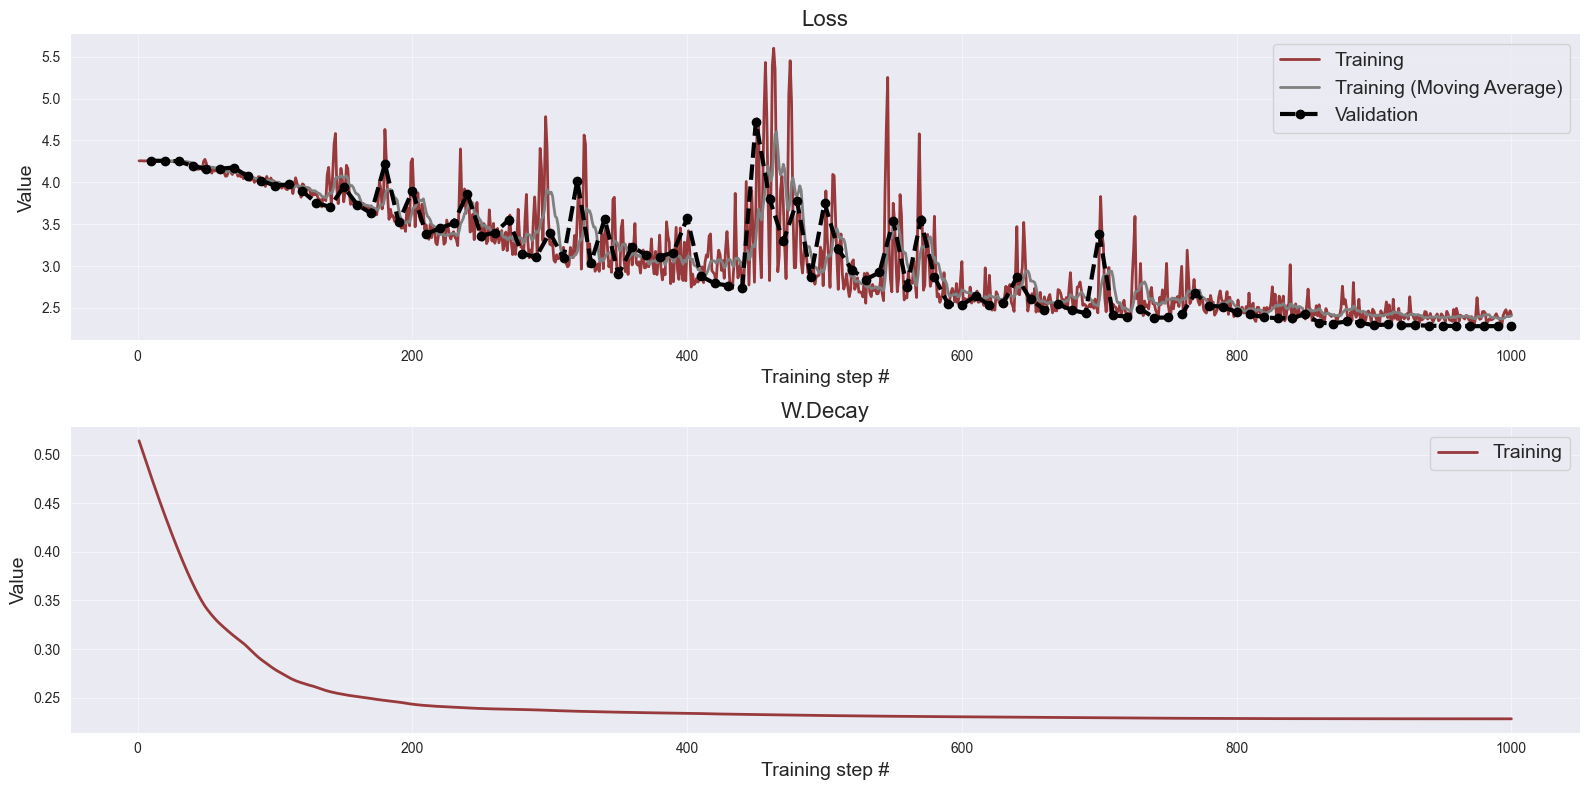

In [166]:
f = bf.diagnostics.plot_losses(history['train_losses'], history['val_losses'], moving_average=True)

### Validation

In [168]:
validation_sim = model(2000)

In [169]:
validation_sim['summary_conditions']

KeyError: 'summary_conditions'

In [170]:
validation_sim = configurator(validation_sim)

In [171]:
post_samples = amortizer.sample(validation_sim, n_samples=200)
post_samples

array([[[-1.5479369 ,  1.8721241 , -1.5321239 ],
        [ 0.31099528,  1.4658786 , -1.096208  ],
        [-0.70398355,  2.1572285 , -0.6802447 ],
        ...,
        [-0.7105787 ,  2.3715253 , -0.7828998 ],
        [ 0.83487767,  2.380882  , -0.57781476],
        [ 1.1608752 ,  2.467827  ,  0.58805114]],

       [[-1.5047486 , -1.4815071 , -0.6186794 ],
        [ 1.2521414 , -1.1008877 ,  0.12026289],
        [ 0.22409487, -1.2270775 ,  0.21888004],
        ...,
        [-1.8794278 , -1.262756  ,  0.82359827],
        [ 0.00805126, -1.1573968 , -0.3266301 ],
        [ 2.7296822 , -1.0968099 , -0.90456796]],

       [[-1.037395  , -1.1027185 , -0.49857342],
        [ 0.8911916 , -0.9689033 , -1.2566489 ],
        [-1.6784296 , -0.9974488 , -0.2572598 ],
        ...,
        [ 1.0896957 , -1.1715426 ,  4.0684156 ],
        [-1.8548155 , -0.98935395, -0.06585256],
        [ 0.8571674 , -1.0580219 , -0.6223614 ]],

       ...,

       [[ 1.1193068 , -0.990295  ,  0.560349  ],
        [-0

In [172]:
post_samples.shape

(2000, 200, 3)

In [173]:
prior_means, prior_stds = prior.estimate_means_and_stds(n_draws=5000)
prior_stds

array([[0.685062 , 0.6787162, 0.5934513]], dtype=float32)

In [185]:
# Prior samples have already been standardized, so the results here are omitted.
prior_samples = validation_sim["parameters"]
prior_samples.shape

(2000, 3)

In [182]:
prior_samples = np.subtract(prior_samples, prior_samples.min(axis=0)) / np.subtract(prior_samples.max(axis=0), prior_samples.min(axis=0))

In [183]:
prior_samples = prior_samples * prior_stds + prior_means

Parameter Recovery

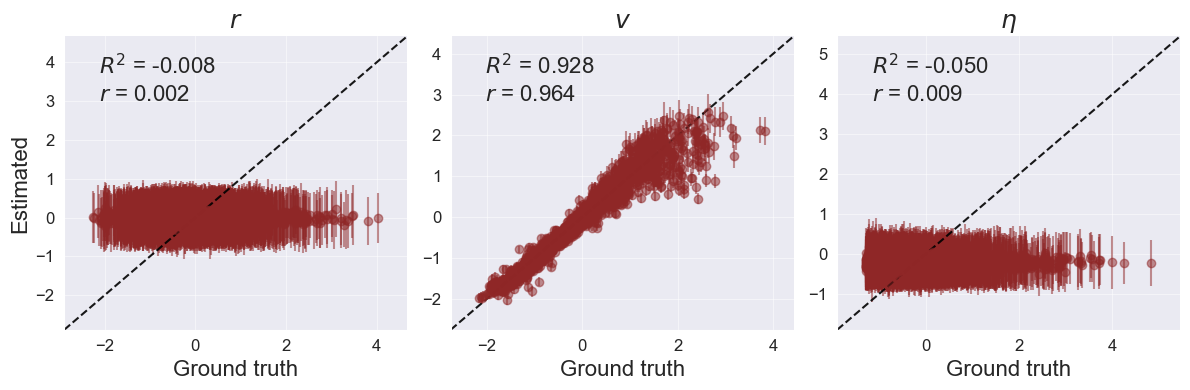

In [186]:
g = bf.diagnostics.plot_recovery(post_samples=post_samples, prior_samples=prior_samples, param_names=param_names)

Simulation-based calibration

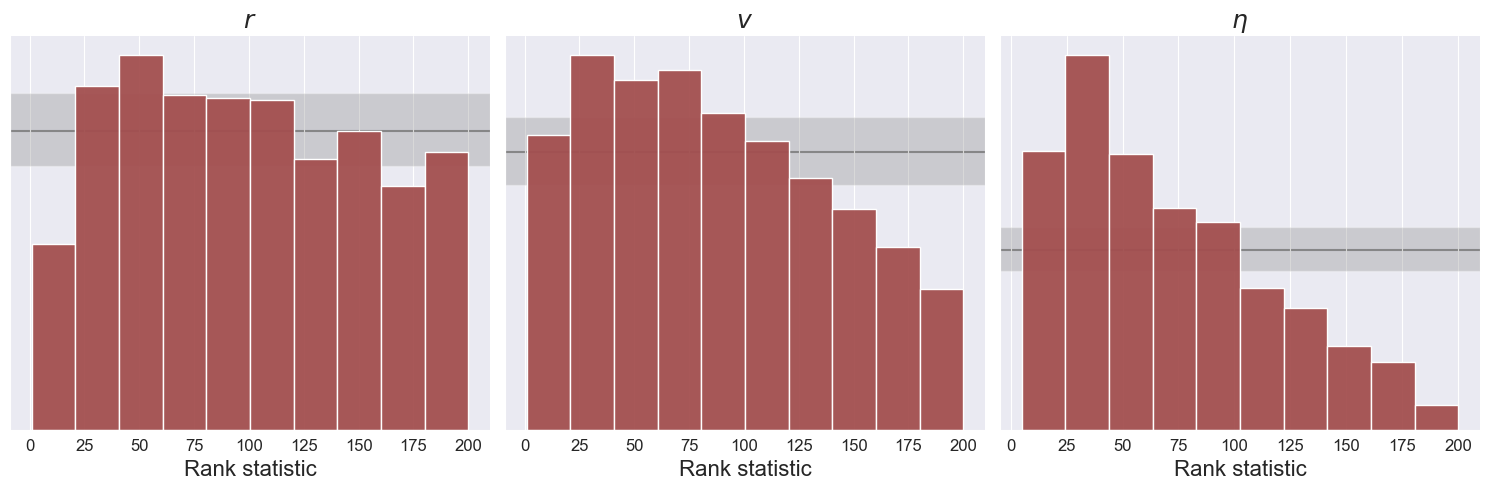

In [147]:
h = bf.diagnostics.plot_sbc_histograms(post_samples=post_samples, prior_samples=prior_samples, param_names=param_names, num_bins=10)

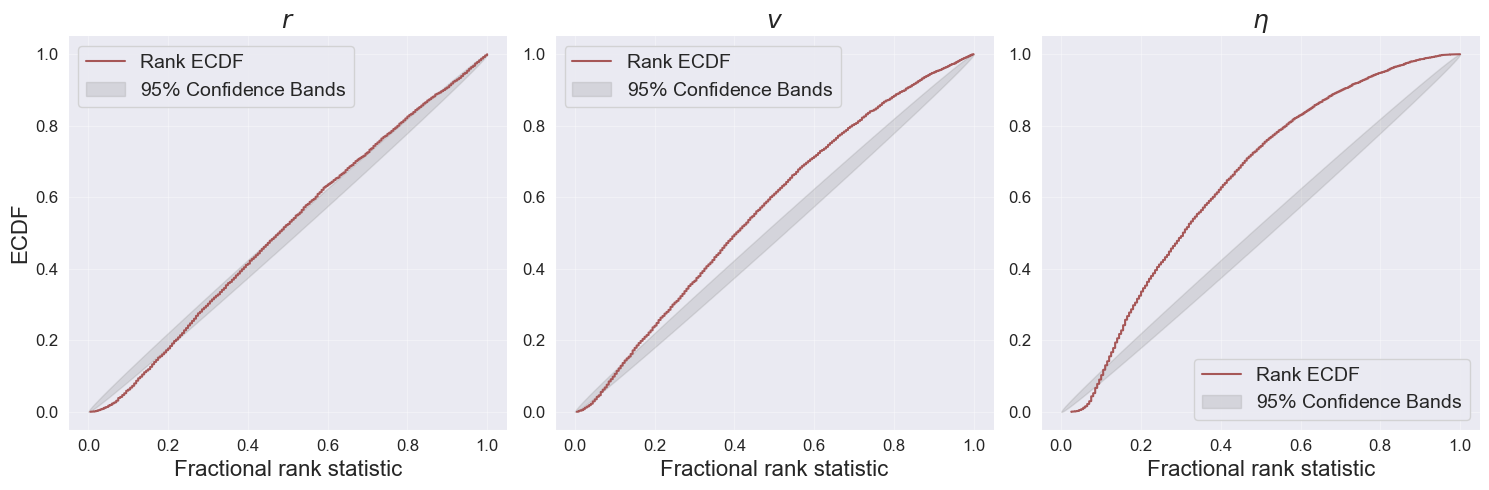

In [148]:
e = bf.diagnostics.plot_sbc_ecdf(post_samples=post_samples, prior_samples=prior_samples, param_names=param_names)

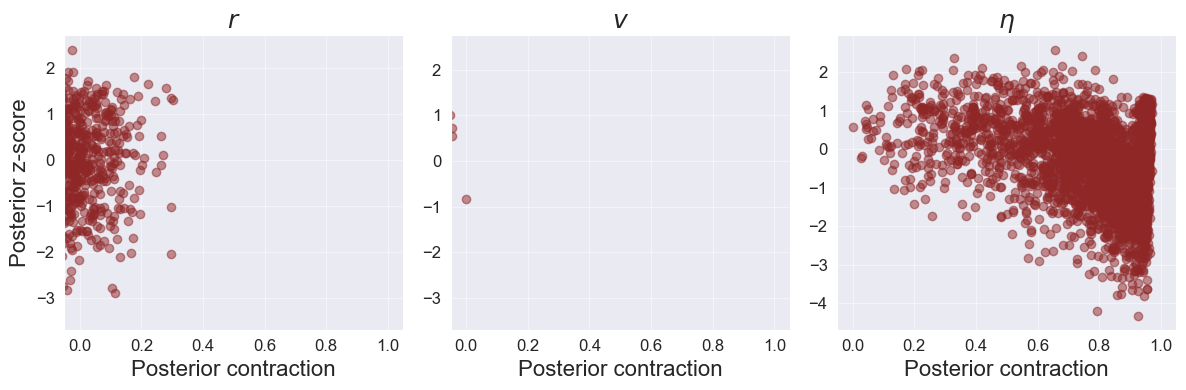

In [91]:
c = bf.diagnostics.plot_z_score_contraction(post_samples=post_samples, prior_samples=prior_samples, param_names=param_names)

In [ ]:
post_samples = 

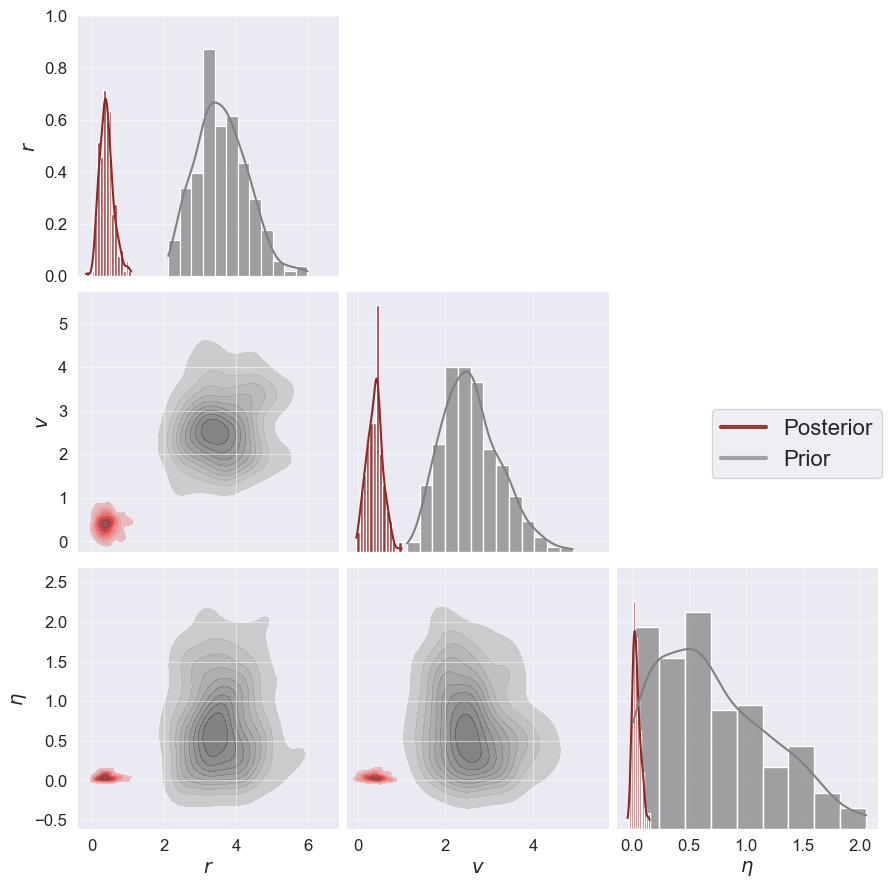

In [92]:
d = bf.diagnostics.plot_posterior_2d(posterior_draws=post_samples[1], prior=prior, param_names=param_names)